From https://gitlab.com/dword4/nhlapi/tree/master

Import numpy, requests, and json modules

In [153]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

Get the rosters for the 2017-2018 season as a json object

In [67]:
team_rosters_2017_2018 = requests.get('https://statsapi.web.nhl.com/api/v1/teams?expand=team.roster&season=20172018')

In [68]:
team_rosters_2017_2018 = team_rosters_2017_2018.json()

Print out all the team names

In [69]:
for i in range(0, len(team_rosters_2017_2018['teams'])):
    print(team_rosters_2017_2018['teams'][i]['name'])

New Jersey Devils
New York Islanders
New York Rangers
Philadelphia Flyers
Pittsburgh Penguins
Boston Bruins
Buffalo Sabres
Montréal Canadiens
Ottawa Senators
Toronto Maple Leafs
Carolina Hurricanes
Florida Panthers
Tampa Bay Lightning
Washington Capitals
Chicago Blackhawks
Detroit Red Wings
Nashville Predators
St. Louis Blues
Calgary Flames
Colorado Avalanche
Edmonton Oilers
Vancouver Canucks
Anaheim Ducks
Dallas Stars
Los Angeles Kings
San Jose Sharks
Columbus Blue Jackets
Minnesota Wild
Winnipeg Jets
Arizona Coyotes
Vegas Golden Knights


Get every player from every team
Makes a players array holding [player_id, player_name, team]

In [70]:
players_2017_2018 = []
for i in range(0, len(team_rosters_2017_2018['teams'])):
    #print(team_rosters_2017_2018['teams'][i]['name'])
    for j in range(0, len(team_rosters_2017_2018['teams'][i]['roster']['roster'])):
        #print(team_rosters_2017_2018['teams'][i]['roster']['roster'][j]['person'])
        player = [team_rosters_2017_2018['teams'][i]['roster']['roster'][j]['person']['id'], 
                  team_rosters_2017_2018['teams'][i]['roster']['roster'][j]['person']['fullName'],
                 team_rosters_2017_2018['teams'][i]['name']]
        if (team_rosters_2017_2018['teams'][i]['roster']['roster'][j]['position']['code'] != 'G'):
            players_2017_2018.append(player)
                                                                    
                                                                    

In [71]:
for i in range(0, len(players_2017_2018)):
    print(players_2017_2018[i])

[8470619, 'Brian Boyle', 'New Jersey Devils']
[8471226, 'Drew Stafford', 'New Jersey Devils']
[8471233, 'Travis Zajac', 'New Jersey Devils']
[8472382, 'Andy Greene', 'New Jersey Devils']
[8473546, 'Michael Grabner', 'New Jersey Devils']
[8473933, 'Ben Lovejoy', 'New Jersey Devils']
[8474034, 'Pat Maroon', 'New Jersey Devils']
[8474625, 'Jimmy Hayes', 'New Jersey Devils']
[8474641, 'Adam Henrique', 'New Jersey Devils']
[8474774, 'Dalton Prout', 'New Jersey Devils']
[8475149, 'Marcus Johansson', 'New Jersey Devils']
[8475151, 'Kyle Palmieri', 'New Jersey Devils']
[8475186, 'John Moore', 'New Jersey Devils']
[8475222, 'Sami Vatanen', 'New Jersey Devils']
[8475791, 'Taylor Hall', 'New Jersey Devils']
[8476207, 'Brian Gibbons', 'New Jersey Devils']
[8476370, 'Blake Pietila', 'New Jersey Devils']
[8476399, 'Blake Coleman', 'New Jersey Devils']
[8476474, 'Stefan Noesen', 'New Jersey Devils']
[8476923, 'Damon Severson', 'New Jersey Devils']
[8477355, 'Will Butcher', 'New Jersey Devils']
[84774

[8480164, 'Henrik Haapala', 'Florida Panthers']
[8470543, 'Chris Kunitz', 'Tampa Bay Lightning']
[8470601, 'Braydon Coburn', 'Tampa Bay Lightning']
[8471339, 'Ryan Callahan', 'Tampa Bay Lightning']
[8471873, 'Anton Stralman', 'Tampa Bay Lightning']
[8471958, 'Dan Girardi', 'Tampa Bay Lightning']
[8473986, 'Alex Killorn', 'Tampa Bay Lightning']
[8474151, 'Ryan McDonagh', 'Tampa Bay Lightning']
[8474564, 'Steven Stamkos', 'Tampa Bay Lightning']
[8474870, 'Tyler Johnson', 'Tampa Bay Lightning']
[8475167, 'Victor Hedman', 'Tampa Bay Lightning']
[8475254, 'Gabriel Dumont', 'Tampa Bay Lightning']
[8475739, 'Michael Bournival', 'Tampa Bay Lightning']
[8476195, 'Cory Conacher', 'Tampa Bay Lightning']
[8476285, 'Matthew Peca', 'Tampa Bay Lightning']
[8476292, 'Ondrej Palat', 'Tampa Bay Lightning']
[8476453, 'Nikita Kucherov', 'Tampa Bay Lightning']
[8476468, 'J.T. Miller', 'Tampa Bay Lightning']
[8476480, 'Vladislav Namestnikov', 'Tampa Bay Lightning']
[8476806, 'J.T. Brown', 'Tampa Bay Lightni

Get the stats for each player as an array of [timeOnIce, assists, goals, pim, shots, games, hits, powerPlayGoals, powerPlayPoints, powerPlayTimeOnIce, evenTimeOnIce, penaltyMinutes, faceOffPct, shotPct, gameWinningGoals, overTimeGoals, shortHandedGoals, shortHandedPoints, shortHandedTimeOnIce, blocked, plusMinus, points, shifts, timeOnIcePerGame, evenTimeOnIcePerGame, shortHandedTimeOnIcePerGame, powerPlayTimeOnIcePerGame]

In [72]:
players_2017_2018_stats = []
for i in range(0, len(players_2017_2018)): 
    stats = requests.get('https://statsapi.web.nhl.com/api/v1/people/' 
                       + str(players_2017_2018[i][0]) 
                       + '/stats?stats=statsSingleSeason&season=20172018').json()
    stats = stats['stats'][0]['splits'][0]['stat']
    stats_array = []
    stats_array.append(stats['timeOnIce'])
    stats_array.append(stats['assists'])
    stats_array.append(stats['goals'])
    stats_array.append(stats['pim'])
    stats_array.append(stats['shots'])
    stats_array.append(stats['games'])
    stats_array.append(stats['hits'])
    stats_array.append(stats['powerPlayGoals'])
    stats_array.append(stats['powerPlayPoints'])
    stats_array.append(stats['powerPlayTimeOnIce'])
    stats_array.append(stats['evenTimeOnIce'])
    stats_array.append(stats['penaltyMinutes'])
    stats_array.append(stats['faceOffPct'])
    stats_array.append(stats['shotPct'])
    stats_array.append(stats['gameWinningGoals'])
    stats_array.append(stats['overTimeGoals'])
    stats_array.append(stats['shortHandedGoals'])
    stats_array.append(stats['shortHandedPoints'])
    stats_array.append(stats['shortHandedTimeOnIce'])
    stats_array.append(stats['blocked'])
    stats_array.append(stats['plusMinus'])
    stats_array.append(stats['points'])
    stats_array.append(stats['shifts'])
    stats_array.append(stats['timeOnIcePerGame'])
    stats_array.append(stats['evenTimeOnIcePerGame'])
    stats_array.append(stats['shortHandedTimeOnIcePerGame'])
    stats_array.append(stats['powerPlayTimeOnIcePerGame'])
    players_2017_2018_stats.append(stats_array)

print(len(players_2017_2018_stats))
print(len(players_2017_2018_stats[0]))
    

KeyboardInterrupt: 

Append the stats for each player to their id, name, and team

In [ ]:
skaters_2017_2018 = []
for i in range(0, len(players_2017_2018)):
    skaters_2017_2018.append(players_2017_2018[i] + players_2017_2018_stats[i])


In [ ]:
print(skaters_2017_2018)

Save the skaters array as csv data for anaylsis 

In [ ]:
np.savetxt('data/skaters_2017_2018.csv', skaters_2017_2018, fmt='%s', delimiter=',')

In [ ]:
def get_csv(y1, y2):
    team_rosters = requests.get('https://statsapi.web.nhl.com/api/v1/teams?expand=team.roster&season=' + y1 + y2)
    #print('https://statsapi.web.nhl.com/api/v1/teams?expand=team.roster&season=' + y1 + y2)
    team_rosters = team_rosters.json()
    players= []
    for i in range(0, len(team_rosters['teams'])):
        #print(team_rosters_2017_2018['teams'][i]['name'])
        for j in range(0, len(team_rosters['teams'][i]['roster']['roster'])):
            #print(team_rosters_2017_2018['teams'][i]['roster']['roster'][j]['person'])
            player = [team_rosters['teams'][i]['roster']['roster'][j]['person']['id'], 
                      team_rosters['teams'][i]['roster']['roster'][j]['person']['fullName'],
                     team_rosters['teams'][i]['name']]
            if (team_rosters['teams'][i]['roster']['roster'][j]['position']['code'] != 'G'):
                players.append(player)
    players_stats = []
    labels = requests.get('https://statsapi.web.nhl.com/api/v1/people/' 
                           + str(players[i][0]) 
                           + '/stats?stats=statsSingleSeason&season=' + y1 + y2).json()
    labels = labels['stats'][0]['splits'][0]['stat']
    header = ['id', 'fullName', 'teamName']
    for label in labels:
        header.append(label)
    #print(labels)
    #print(header)
    for i in range(0, len(players)): 
        #print(str(players[i][0]))
        stats = requests.get('https://statsapi.web.nhl.com/api/v1/people/' 
                           + str(players[i][0]) 
                           + '/stats?stats=statsSingleSeason&season=' + y1 + y2).json()
        if(stats['stats'][0]['splits'] == []):
            players_stats.append([0] * len(labels))
            continue
        stats = stats['stats'][0]['splits'][0]['stat']
        
        stats_array = []
        for label in labels:
            if label in stats:
                stats_array.append(stats[label])
            else:
                stats_array.append(0)
        players_stats.append(stats_array)
        
    skaters = []
    skaters.append(header)
    for i in range(0, len(players)):
        skaters.append(players[i] + players_stats[i])
    return skaters

In [ ]:
skaters = get_csv('2016', '2017')
np.savetxt('data/skaters_2016_2017.csv', skaters, fmt='%s', delimiter=',')

In [ ]:
skaters = get_csv('2015', '2016')
np.savetxt('data/skaters_2015_2016.csv', skaters, fmt='%s', delimiter=',')

In [ ]:
skaters = get_csv('2014', '2015')
np.savetxt('data/skaters_2014_2015.csv', skaters, fmt='%s', delimiter=',')

In [ ]:
skaters = get_csv('1970', '1971')
np.savetxt('data/skaters_1970_1971.csv', skaters, fmt='%s', delimiter=',')

In [ ]:
stats = requests.get('https://statsapi.web.nhl.com/api/v1/people/' 
                       + str(8445135) 
                       + '/stats?stats=statsSingleSeason&season=19171918').json()

In [ ]:
stats

In [ ]:
stats = stats = stats['stats'][0]['splits'][0]['stat']

In [ ]:
player_stats = []
for x in stats:
    player_stats.append(x)

In [ ]:
player_stats

In [ ]:
def get_data(start, end):
    for i in range(start, end):
        if(i == 2004):
            continue
        print("Getting data for " + str(i) + "-" + str(i+1) + " season.")
        skaters = get_csv(str(i), str(i+1))
        np.savetxt('data/skaters_' + str(i) + '_' + str(i+1) + '.csv', skaters, fmt='%s', delimiter=',')

In [ ]:
get_data(2005,2018)

Get Team data

In [ ]:
teams = requests.get('https://statsapi.web.nhl.com/api/v1/teams?season=20172018')
teams = teams.json()

In [ ]:
team_id_name = []
for i in range(0, len(teams['teams'])):
    team_arr = [teams['teams'][i]['id'], teams['teams'][i]['name']]
    team_id_name.append(team_arr)
#print(team_id_name)

labels = requests.get('https://statsapi.web.nhl.com/api/v1/teams/' 
                           + str(team_id_name[0][0])
                           + '/stats?stats=statsSingleSeason&season=19901991').json()
labels = labels['stats'][0]['splits'][0]['stat']
header = ['id', 'teamName']
for label in labels:
    header.append(label)
#print(header)

team_stats = []
for i in range(0, len(team_id_name)):
    stats = requests.get('https://statsapi.web.nhl.com/api/v1/teams/' 
                         + str(team_id_name[i][0]) 
                         + '/stats?stats=statsSingleSeason&season=19901991').json()
    if(stats['stats'][0]['splits'] == []):
        team_stats.append([0] * len(labels))
        continue
    stats = stats['stats'][0]['splits'][0]['stat']
    stats_array = []
    for label in labels:
        if label in stats:
            stats_array.append(stats[label])
        else:
            stats_array.append(0)
    team_stats.append(stats_array)

    
teams_stats_final = []
teams_stats_final.append(header)
for i in range(0, len(team_id_name)):
    teams_stats_final.append(team_id_name[i] + team_stats[i])    

np.savetxt('team_data/teams_19901991.csv', teams_stats_final, fmt='%s', delimiter=',')

In [74]:
def get_csv_team(y1, y2):
    teams = requests.get('https://statsapi.web.nhl.com/api/v1/teams?season=' + str(y1) + str(y2))
    teams = teams.json()
    team_id_name = []
    for i in range(0, len(teams['teams'])):
        team_arr = [teams['teams'][i]['id'], teams['teams'][i]['name']]
        team_id_name.append(team_arr)

    labels = requests.get('https://statsapi.web.nhl.com/api/v1/teams/' 
                           + str(team_id_name[0][0])
                           + '/stats?stats=statsSingleSeason&season=' + str(y1) + str(y2)).json()
    labels = labels['stats'][0]['splits'][0]['stat']
    header = ['id', 'teamName']
    for label in labels:
        header.append(label)

    team_stats = []
    for i in range(0, len(team_id_name)):
        stats = requests.get('https://statsapi.web.nhl.com/api/v1/teams/' 
                             + str(team_id_name[i][0]) 
                             + '/stats?stats=statsSingleSeason&season=' + str(y1) + str(y2)).json()
        if(stats['stats'][0]['splits'] == []):
            team_stats.append([0] * len(labels))
            continue
        stats = stats['stats'][0]['splits'][0]['stat']
        stats_array = []
        for label in labels:
            if label in stats:
                stats_array.append(stats[label])
            else:
                stats_array.append(0)
        team_stats.append(stats_array)

    
    teams_stats_final = []
    teams_stats_final.append(header)
    for i in range(0, len(team_id_name)):
        teams_stats_final.append(team_id_name[i] + team_stats[i]) 
    return teams_stats_final

In [ ]:
def get_team_data(start, end):
    for i in range(start, end):
        if(i == 2004):
            continue
        print("Getting data for " + str(i) + "-" + str(i+1) + " season.")
        data = get_csv_team(str(i), str(i+1))
        np.savetxt('team_data/teams_' + str(i) + '_' + str(i+1) + '.csv', data, fmt='%s', delimiter=',')

In [ ]:
get_team_data(1917,2018)

In [ ]:
games = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?startDate=2017-10-04&endDate=2018-06-07')

In [ ]:
games = games.json()

In [ ]:
def get_team_stats(id):
    for i in range(0, len(team_data_2017_2018)):
        if team_data_2017_2018[i][0] == id:
            return i

In [166]:
team_data_2017_2018 = get_csv_team(2017, 2018)
header = team_data_2017_2018[0][3:]
header = header *2
# print(header)
# games_2017_2018 = [['winner', 'awayID', 'homeID'] + header]
games_2017_2018 = []
for date in games['dates']:
    for game in date['games']:
        away_ID = game['teams']['away']['team']['id']
        home_ID = game['teams']['home']['team']['id']
        if away_ID > 80:
            continue
        away_score = game['teams']['away']['score']
        home_score = game['teams']['home']['score']
        winner = 0
        away_stats = team_data_2017_2018[get_team_stats(away_ID)][3:]
        home_stats = team_data_2017_2018[get_team_stats(home_ID)][3:]
        if home_score > away_score:
            winner = 1
        games_2017_2018.append([winner,
                                away_ID, 
                                home_ID] +
                                away_stats +
                                home_stats)

In [167]:
np.savetxt('game_data/game_data_2017_2018.csv', games_2017_2018, fmt='%s', delimiter=',')

In [75]:
team_data_2017_2018 = get_csv_team(2017, 2018)

In [78]:
def get_team_stats(id):
    for i in range(0, len(team_data_2017_2018)):
        if team_data_2017_2018[i][0] == id:
            return i
    

In [81]:
index = get_team_stats(10)

In [84]:
team_data_2017_2018[index][3:]

[49,
 26,
 7,
 105,
 '64.0',
 3.293,
 2.805,
 1.1835,
 '25.0',
 56.0,
 43.0,
 224.0,
 '81.4',
 32.1951,
 33.8537,
 0.78,
 0.313,
 0.838,
 0.861,
 0.5,
 0.652,
 5187.0,
 2688.0,
 2499.0,
 '51.8',
 10.2,
 0.917]

In [168]:
data_regression = pd.read_csv('game_data/game_data_2017_2018.csv', header=None, names=['winner', 'awayID', 'homeID'] + header)
data_regression.head()

,winner,awayID,homeID,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,...,winLeadFirstPer.1,winLeadSecondPer.1,winOutshootOpp.1,winOutshotByOpp.1,faceOffsTaken.1,faceOffsWon.1,faceOffsLost.1,faceOffWinPercentage.1,shootingPctg.1,savePctg.1
0,0,10,52,49,26,7,105,64.0,3.293,2.805,...,0.882,0.955,0.659,0.579,5055.0,2649.0,2406.0,52.4,10.3,0.917
1,0,19,5,44,32,6,94,57.3,2.720,2.707,...,0.821,0.923,0.640,0.483,5118.0,2572.0,2546.0,50.2,9.6,0.903
2,1,20,22,37,35,10,84,51.2,2.634,2.963,...,0.783,0.913,0.463,0.378,4917.0,2394.0,2523.0,48.7,8.4,0.901
3,0,4,28,42,26,14,98,59.8,3.037,2.878,...,0.833,0.909,0.500,0.583,4991.0,2558.0,2433.0,51.2,9.1,0.909
4,1,18,6,53,18,11,117,71.3,3.183,2.488,...,0.857,0.892,0.680,0.577,5078.0,2577.0,2501.0,50.8,9.9,0.912


In [187]:
def prepare(data):
    X = data.iloc[:,3:].values

    # we normalize X
    maxX = np.max(X, axis=0)
    minX = np.min(X, axis=0)
    X = (X-minX)/(maxX-minX)

    # we insert an all-ones column at index 0
    X = np.insert(X, 0, 1, axis=1)
    
    # get the first column of the data
    y = data.iloc[:,0:1].values
    
    # we normalize y
#     maxy = np.max(y, axis=0)
#     miny = np.min(y, axis=0)
#     y = (y-miny)/(maxy-miny)

    #where_are_zeros = (y==0)
    #y[where_are_zeros] = -1
    return X,y

In [193]:
X,y = prepare(data_regression)

print(X)
print(y)

[[ 1.          0.82758621  0.2962963  ...,  0.82828283  0.83870968  0.8       ]
 [ 1.          0.65517241  0.51851852 ...,  0.60606061  0.61290323
   0.33333333]
 [ 1.          0.4137931   0.62962963 ...,  0.45454545  0.22580645
   0.26666667]
 ..., 
 [ 1.          0.89655172  0.22222222 ...,  0.62626263  1.          0.53333333]
 [ 1.          0.89655172  0.22222222 ...,  0.62626263  1.          0.53333333]
 [ 1.          0.82758621  0.2962963  ...,  0.47474747  0.74193548  0.6       ]]
[[0]
 [0]
 [1]
 ..., 
 [1]
 [1]
 [0]]


In [171]:
def error_mean_error_regresesion(X,y,w):
    return (1/(2*len(y))) * (np.sum((y-w@X.T)**2))

/Users/nboulton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
/Users/nboulton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
/Users/nboulton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in add
  


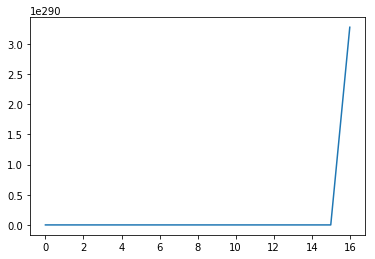

In [186]:
def fit_regression(X,y,kappa,iter):
    w = np.zeros((1,X.shape[1]))
    E = []

    #TODO
    for i in range(0,iter):
        E.append(error_mean_error_regresesion(X,y,w))
        w = w + kappa*((1/len(y))*(np.sum((y-w@X.T).T*X, axis=0, keepdims=True)))
    return w,E

kappa = [0.01]
for i in range(0, len(kappa)):
    w,E = fit_regression(X,y,kappa[i],100)
    plt.plot(E)
    plt.show()

In [189]:
#TODO
def error(x,y,w):
    return np.log(1+np.exp(-y*x@w.T))

#TODO
def error_mean(X,y,w):
    return sum(error(X,y,w))/len(y)

In [190]:
#TODO
def grad(x,y,w):
    return (y*x)/(1+np.exp(y*x@w.T))

#TODO
def grad_mean(X,y,w):
    return -1/len(y)*sum(grad(X,y,w))

In [191]:
def fit(X,y,kappa,iter):
    w = np.zeros((1,X.shape[1]))
    E = []

    #TODO
    for i in range(0,iter):
        E.append(error_mean(X,y,w))
        w = w - kappa*grad_mean(X,y,w)
    return w,E

[[ 0.460963    0.20550891  0.27467027  0.25520958  0.19981204  0.20013742
   0.17319227  0.22591891  0.19616712  0.19097444  0.21612115  0.2314589
   0.20079661  0.23489255  0.23620293  0.21990972  0.22663086  0.2298013
   0.20324398  0.24878817  0.20543597  0.20206506  0.18313165  0.25585648
   0.27336273  0.26246728  0.18258048  0.20318546  0.24463489  0.23942455
   0.23487415  0.23774454  0.23809333  0.20144466  0.19807912  0.22624712
   0.20753411  0.2307004   0.22141648  0.20427884  0.25120079  0.24728302
   0.20884025  0.2619264   0.26129494  0.22601359  0.27793117  0.24121715
   0.23260754  0.18973006  0.26207323  0.27141621  0.26715894  0.20962106
   0.2279122 ]]


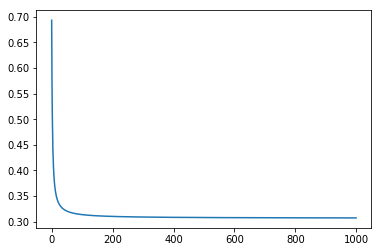

In [210]:
w,E = fit(X,y,0.1,1000)
print(w)
plt.plot(E)
plt.show()

In [211]:
def predict(w, X):
    pred = 1/(1+np.exp(X@-w.T))
    for n in range(0, len(pred)):
        if(pred[n] < 0.5):
            pred[n] = 0
        else:
            pred[n] = 1
    return pred
#TODO
def accuracy(y,y_pred):
    acc = 0
    for n in range(0,len(y)):
        if(y[n] == y_pred[n]):
            acc = acc +1
    return 1-((acc)/len(y))

y_pred = predict(w,X)
#print(y_pred)
print( accuracy(y,y_pred) )

0.44206642066420665


In [212]:
def split_train_test(X,y,pct=80):
    n = X.shape[0]
    s = round(n * pct / 100)
    
    indices = np.random.permutation(n)
    train_idx, test_idx = indices[:s], indices[s:]
    
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx,:], y[test_idx,:]
    
    return X_train, y_train, X_test, y_test

[[ 0.46008975  0.20552901  0.2733909   0.25568399  0.20002201  0.2003468
   0.17353145  0.22530662  0.19602705  0.19096597  0.21574569  0.23119583
   0.19980659  0.23377465  0.23718054  0.22025583  0.22547725  0.23072832
   0.20383565  0.24901024  0.20535951  0.20155759  0.18117673  0.25324757
   0.27408918  0.26000704  0.18255447  0.20366971  0.24449752  0.23772963
   0.23710261  0.23807548  0.23841616  0.2019009   0.19648314  0.22642831
   0.20872193  0.23270147  0.21868165  0.20724386  0.25536775  0.2415447
   0.20875726  0.26237705  0.2611117   0.22403879  0.27420218  0.23973535
   0.23423065  0.19142272  0.26077707  0.27375075  0.26467456  0.21251538
   0.22933682]]


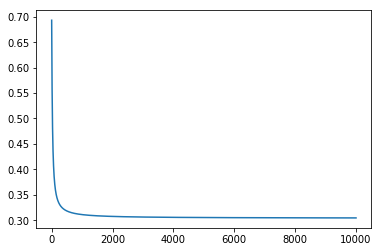

0.4575645756457565


In [214]:
X_train, y_train, X_test, y_test = split_train_test(X,y,pct=80)
w,E = fit(X_train,y_train,0.01,10000)
print(w)
plt.plot(E)
plt.show()
y_pred = predict(w,X_test)
print( accuracy(y_test,y_pred) )